In [1]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [85]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import joblib
import torch
import re

### Загрузка данных

In [23]:
df = pd.read_csv('/content/expanded_requests (1).csv')

In [24]:
df

,request_id,date,sector,client_request,commercial_proposal,budget_est,status
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted
...,...,...,...,...,...,...,...
995,R-1995,2023-10-27,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$2961,Accepted
996,R-1996,2023-09-28,IT Security,Need a quote for SSL configuration by tomorrow.,Professional SSL configuration delivery. High ...,$2596,Pending
997,R-1997,2023-11-19,Data Science,Need a quote for PowerBI dashboard by tomorrow.,Professional PowerBI dashboard delivery. High ...,$3966,Rejected
998,R-1998,2023-09-28,Design,Can you help with Logo redesign? We are a star...,Professional Logo redesign delivery. High qual...,$3617,Rejected


In [25]:
print("Загрузка модели эмбеддингов all-MiniLM-L6-v2...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Загрузка модели эмбеддингов all-MiniLM-L6-v2...


### Обработка признака budget_est

In [26]:
def clean_budget(value):
    if pd.isna(value):
        return 0
    match = re.search(r"(\d+(\.\d+)?)", str(value))
    if match:
        return float(match.group(1))
    return 0

In [27]:
df['budget_cleaned'] = df['budget_est'].apply(clean_budget)
df['is_variable_rate'] = df['budget_est'].astype(str).str.contains('/word|/week', na=False)
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,budget_cleaned,is_variable_rate
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,1460.0,False
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,3396.0,False
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,3737.0,False
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,4716.0,False
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1591.0,False


In [29]:
def train_and_evaluate_mvp(df):
    print("Cleaning data and engineering features...")

    sector_means = df.groupby('sector')['budget_cleaned'].transform('mean')
    df['budget_relative_ratio'] = df['budget_cleaned'] / (sector_means + 1)


    print("Generating embeddings (this may take 1-2 mins)...")
    # Encode both requests and proposals into dense vectors
    req_embs = embedder.encode(df['client_request'].fillna('').tolist(), convert_to_tensor=True)
    prop_embs = embedder.encode(df['commercial_proposal'].fillna('').tolist(), convert_to_tensor=True)

    # Calculate Semantic Similarity (Cosine Similarity) between Request and Proposal
    cosine_scores = util.cos_sim(req_embs, prop_embs)
    df['semantic_similarity'] = torch.diagonal(cosine_scores).cpu().numpy()

    # --- C. DIMENSIONALITY REDUCTION (PCA) ---
    print("Reducing dimensions using PCA...")
    pca = PCA(n_components=10, random_state=42)
    req_pca = pca.fit_transform(req_embs.cpu().numpy())
    pca_cols = [f'pca_{i}' for i in range(10)]
    df_pca = pd.DataFrame(req_pca, columns=pca_cols, index=df.index)

    # Final feature assembly
    features_from_df = ['budget_cleaned', 'sector', 'semantic_similarity', 'budget_relative_ratio']
    X = pd.concat([df[features_from_df], df_pca], axis=1)
    y = (df['status'] == 'Accepted').astype(int)

    return X, y, pca

In [30]:
df.head()

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,budget_cleaned,is_variable_rate
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,1460.0,False
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,3396.0,False
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,3737.0,False
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,4716.0,False
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1591.0,False


### Подготовка данных и обучение модели

In [31]:
# Подготовка данных
X, y, pca = train_and_evaluate_mvp(df)
categorical_features = ['sector']

Cleaning data and engineering features...
Generating embeddings (this may take 1-2 mins)...
Reducing dimensions using PCA...


In [32]:
# Создаем колонку 'target': 1, если заказ принят ('Accepted'), иначе 0
df['target'] = (df['status'] == 'Accepted').astype(int)

In [33]:
df

,request_id,date,sector,client_request,commercial_proposal,budget_est,status,budget_cleaned,is_variable_rate,budget_relative_ratio,semantic_similarity,target
0,R-1000,2023-10-18,SEO,Need a quote for Backlink strategy by tomorrow.,Professional Backlink strategy delivery. High ...,$1460,Rejected,1460.0,False,0.604543,0.568218,0
1,R-1001,2023-10-26,SEO,Need a quote for Keyword research by tomorrow.,Professional Keyword research delivery. High q...,$3396,Rejected,3396.0,False,1.406185,0.357490,0
2,R-1002,2023-10-19,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$3737,Negotiating,3737.0,False,1.453603,0.697204,0
3,R-1003,2023-10-13,Mobile App,I need a Android bug fix for my tech startup.,Professional Android bug fix delivery. High qu...,$4716,Negotiating,4716.0,False,1.904230,0.753847,0
4,R-1004,2023-09-24,Mobile App,Need a quote for iOS MVP by tomorrow.,"Professional iOS MVP delivery. High quality, q...",$1591,Accepted,1591.0,False,0.642415,0.526614,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,R-1995,2023-10-27,Design,Can you help with Vector illustrations? We are...,Professional Vector illustrations delivery. Hi...,$2961,Accepted,2961.0,False,1.151757,0.697204,1
996,R-1996,2023-09-28,IT Security,Need a quote for SSL configuration by tomorrow.,Professional SSL configuration delivery. High ...,$2596,Pending,2596.0,False,1.023172,0.615513,0
997,R-1997,2023-11-19,Data Science,Need a quote for PowerBI dashboard by tomorrow.,Professional PowerBI dashboard delivery. High ...,$3966,Rejected,3966.0,False,1.579796,0.624532,0
998,R-1998,2023-09-28,Design,Can you help with Logo redesign? We are a star...,Professional Logo redesign delivery. High qual...,$3617,Rejected,3617.0,False,1.406925,0.744560,0


In [82]:
skf = StratifiedKFold(n_splits=85, shuffle=True, random_state=42)
cv_scores = []

In [83]:
for fold, (t_idx, v_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[t_idx], X.iloc[v_idx]
    y_train, y_val = y.iloc[t_idx], y.iloc[v_idx]

    # Hyperparameters optimized for stability and generalization
    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.1,
        depth=3,
        l2_leaf_reg=100,
        bootstrap_type='Bernoulli',
        subsample=1,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        random_seed=42,
        verbose=0,
        early_stopping_rounds=300
    )

    model.fit(
        Pool(X_train, y_train, cat_features=['sector']),
        eval_set=Pool(X_val, y_val, cat_features=['sector'])
    )

    # Scoring the fold
    score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    cv_scores.append(score)
    print(f"Fold {fold+1} ROC-AUC: {score:.4f} (Best Iter: {model.get_best_iteration()})")

print(f"\n MEAN ROC-AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

final_model = CatBoostClassifier(**model.get_params())
final_model.fit(Pool(X, y, cat_features=['sector']), verbose=0)

Fold 1 ROC-AUC: 0.7500 (Best Iter: 212)
Fold 2 ROC-AUC: 0.9688 (Best Iter: 3)
Fold 3 ROC-AUC: 0.9688 (Best Iter: 78)
Fold 4 ROC-AUC: 0.5000 (Best Iter: 17)
Fold 5 ROC-AUC: 0.8125 (Best Iter: 4)
Fold 6 ROC-AUC: 0.6406 (Best Iter: 1)
Fold 7 ROC-AUC: 0.6875 (Best Iter: 20)
Fold 8 ROC-AUC: 1.0000 (Best Iter: 2)
Fold 9 ROC-AUC: 0.8438 (Best Iter: 2)
Fold 10 ROC-AUC: 0.8750 (Best Iter: 40)
Fold 11 ROC-AUC: 0.9375 (Best Iter: 5)
Fold 12 ROC-AUC: 0.8750 (Best Iter: 9)
Fold 13 ROC-AUC: 0.5312 (Best Iter: 6)
Fold 14 ROC-AUC: 0.7188 (Best Iter: 1)
Fold 15 ROC-AUC: 0.9219 (Best Iter: 2)
Fold 16 ROC-AUC: 0.8125 (Best Iter: 2)
Fold 17 ROC-AUC: 0.8594 (Best Iter: 3)
Fold 18 ROC-AUC: 0.8125 (Best Iter: 13)
Fold 19 ROC-AUC: 0.7812 (Best Iter: 14)
Fold 20 ROC-AUC: 0.4844 (Best Iter: 7)
Fold 21 ROC-AUC: 0.6719 (Best Iter: 0)
Fold 22 ROC-AUC: 0.9688 (Best Iter: 19)
Fold 23 ROC-AUC: 0.7500 (Best Iter: 61)
Fold 24 ROC-AUC: 0.3906 (Best Iter: 5)
Fold 25 ROC-AUC: 1.0000 (Best Iter: 15)
Fold 26 ROC-AUC: 0.5312

<Axes: >

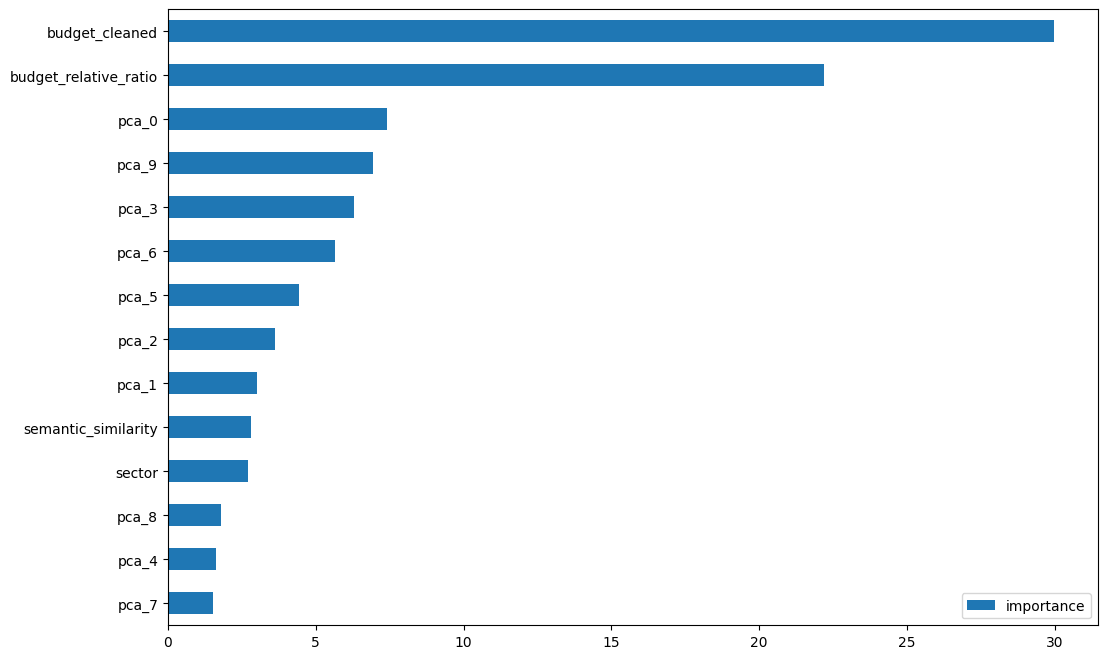

In [84]:
imp = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))